In [330]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [206]:
# Генерируем две случайные выборки с биномиальным распределением, которые принадлежат одной генеральной совокупности.
# Проводим Z-тест. P-value должно быть близкое к единице т.к. выборки принадлежат одной совокупности.
# Повторяем 1000 раз, смотрим какая доля тестов с P-value менее 0.05

In [207]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 1000)
    b = np.random.binomial(1, 0.03, 1000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 4002.39it/s]

0.056


In [208]:
# Видим, что доля тестов с P-value <= 0.05 около 5%. Значит в 5% случаев тест находит разницу там, где ее на самом деле нет.
# Или можно сказать, что тест в 95% верно определяет, что разницы нет. Такая вероятность в статистике определяется значением параметра alpha.
# Например, если alpha = 0.05 мы принимаем погрешность, что 5% случаев мы будем отвергать верную нулевую гипотезу.

<AxesSubplot:>

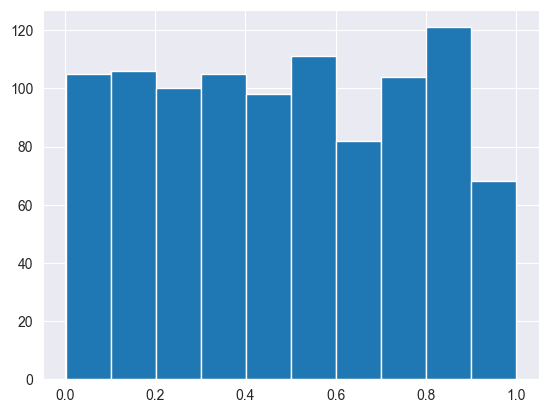

In [209]:
# Построим гистограмму распределения P-value
result.hist()

In [210]:
# Изменим условия. Смоделируем ситуацию, когда выборки не принадлежат одной генеральной совокупности.
# Посмотрим, какая доля тестов будет с P-value > 0.05.

In [211]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 1000)
    b = np.random.binomial(1, 0.035, 1000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result >= 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 3753.81it/s]

0.914


In [212]:
# Тест в 90% случаев показывает, что выборки принадлежат одной генеральной совокупности, хотя это не так. Такая ситуация в статистике называется
# ошибка второго рода, когда мы принимаем неверную нулевую гипотезу. Можно переформулировать, что мы не смогли обнаружить отличия там где они есть.
# Параметр, который отвечает за вероятность найти отличия в ситуации когда они есть называется мощность. В нашем случае он равен 10%, что очень мало.
# Предположим, что тест не может определить изменение в 0.5 процентных пункта на выборках в 1000 наблюдений.

In [213]:
# Изменим условия теста: увеличим размер выборки до 10 000 наблюдений, P-value <= 0.05

In [214]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 10000)
    b = np.random.binomial(1, 0.035, 10000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 1761.94it/s]

0.546


In [215]:
# Уже лучше. Тест дает ложноположительный результат примерно в 50% случаев. Увеличиваем размер выборки до 20 000 наблюдений.

In [216]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 20000)
    b = np.random.binomial(1, 0.035, 20000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 1210.62it/s]

0.833


In [217]:
# Тест верно определяет разницу между выборками в 80% случаев. Что же неплохо. В статистике power=80% считается приемлемым.

<AxesSubplot:>

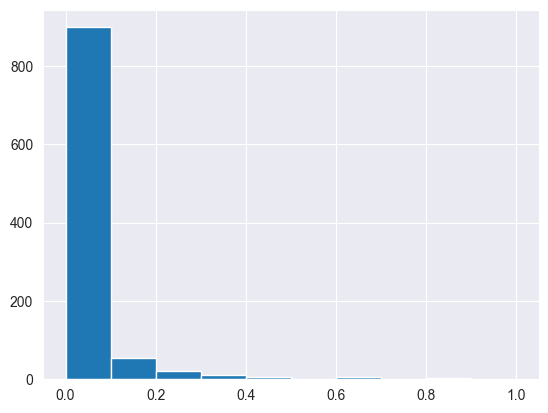

In [218]:
# Построим гистограмму распределения
result.hist()

In [219]:
# Итак, методом тыка мы нашли необходимый размер выборки в 20 000 наблюдений. Вывод: размер выборки влияет на точность теста.
# Попробуем более научный подход определения размера выборки. Для этого используем statsmodels.stats.power. NormalIndPower.solve_power
# Тест на вход принимает параметры: ожидаемое изменение, размер контрольной выборки, alpha, power, соотношение контрольной и тестовой групп,
# тип теста: меньше, больше или двухсторонний. Тест возвращает параметр, который не определен. Например, нам нужно узнать размер выборки.
# Не будет его указывать.

In [220]:
es = sms.proportion_effectsize(0.03, 0.035)
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))
print(es)
print(sample_size)

-0.02821746104476741
19715


In [221]:
# Для генерации выборок мы использовали биномиальное распределение, для вычисления P-value использовали Z-тест.
# Попробуем другие тесты.

In [222]:
# Первый в нашей очереди T-тест. Используем ttest_ind из библиотеки scipy.stats. Тест принимает параметры: a, b это две выборки,
# которые содержат положительные и отрицательные результаты, в нашем случае массив из нулей и единиц [1, 0, 0, 0, 1], equal_var — по умолчанию False.
# False — выборки принадлежат одной генеральной совокупности с одинаковой дисперсией, используется обычный T-тест, True — выборки принадлежат
# разным генеральным совокупностям, используется T-тест Уэлча.
# !!! Обрати внимание, equal_var=False

In [223]:
result = []
a_st_dev = []
b_st_dev = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    a_st_dev.append(np.std(a))
    b = np.random.binomial(1, 0.03, 19715)
    b_st_dev.append(np.std(b))
    p_value = ttest_ind(a, b, equal_var=False)[1]
    result.append(p_value)
a_result = pd.Series(a_st_dev)
b_result = pd.Series(b_st_dev)
result = pd.Series(result)
print('Среднее стандартное отклонение для группы A:', a_result.mean())
print('Среднее стандартное отклонение для группы B:', b_result.mean())
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 672.62it/s]

Среднее стандартное отклонение для группы A: 0.17052783085073167
Среднее стандартное отклонение для группы B: 0.17046655845158382
alpha=0.054


<AxesSubplot:>

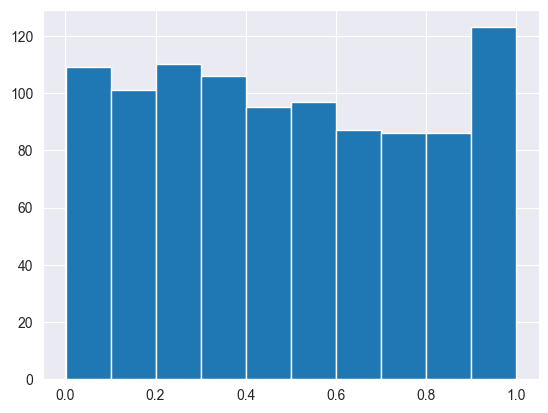

In [224]:
result.hist()

In [225]:
result = []
a_st_dev = []
b_st_dev = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    a_st_dev.append(np.std(a))
    b = np.random.binomial(1, 0.035, 19715)
    b_st_dev.append(np.std(b))
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
a_result = pd.Series(a_st_dev)
b_result = pd.Series(b_st_dev)
result = pd.Series(result)
print('Среднее стандартное отклонение для группы A:', a_result.mean())
print('Среднее стандартное отклонение для группы B:', b_result.mean())
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 729.53it/s]

Среднее стандартное отклонение для группы A: 0.1704797019821507
Среднее стандартное отклонение для группы B: 0.1837688023221973
power=0.808


<AxesSubplot:>

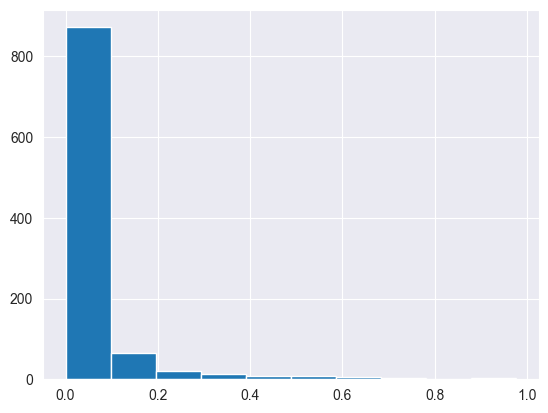

In [226]:
result.hist()

In [227]:
# Вывод T-тест дает схожие показатели alpha и power, распределение P-value

In [228]:
# Для разнообразия попробуем непараметрический U-тест Манна-Уитни. Он хорош для малых выборок или когда есть значительные выбросы (высокая дисперсия)
# или для анализа непрерывных переменных

In [229]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    b = np.random.binomial(1, 0.03, 19715)
    p_value = mannwhitneyu(a, b)[1]
    result.append(p_value)
result = pd.Series(result)
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s]

alpha=0.059


In [230]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    b = np.random.binomial(1, 0.035, 19715)
    p_value = mannwhitneyu(a, b)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:24<00:00, 40.28it/s]

power=0.804


In [231]:
# Манн-Уитни дал схожие результаты.

In [235]:
# А теперь очень интересное наблюдение. Возьмем нормальное распределение и сделаем T-test

In [282]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.normal(0.03, 0.017, 19715)
    b = np.random.normal(0.035, 0.018, 19715)
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 612.03it/s]

power=1.0


In [238]:
# Мы видим мощность в 100% Почему так получилось? Метод random.normal генерирует и нормально распределяет нам средние. В нашем примере получается,
# что мы взяли 19715 выборок из генеральной совокупности, посчитали среднее для каждой выборки, получили их P-value и так проделали 1000 раз.

In [240]:
# Найдем необходимый размер выборки для нормального распределения. В этом нам поможет TTestIndPower.solve_power, он аналогичен
# NormalIndPower.solve_power. Разница в том, что TTestIndPower для Т-теста, NormalIndPower для Z-теста. Для расчета effect size воспользуемся
# формулой (X̄a - X̄b) / standard deviation

In [291]:
es = (0.035 - 0.03) / 0.017
sample_size = round(sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))
print('sample_size:', sample_size)

sample_size: 182


In [294]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.normal(0.03, 0.017, 182)
    b = np.random.normal(0.03, 0.017, 182)
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
result = pd.Series(result)
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:00<00:00, 3340.38it/s]


alpha=0.044


In [292]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.normal(0.03, 0.017, 182)
    b = np.random.normal(0.035, 0.018, 182)
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:00<00:00, 3417.44it/s]

power=0.777


In [295]:
# Очень важно! Для расчета размера выборки при биномиальном распределении effect size считаем с помощью proportion_effectsize,
# для стандартного распределения с помощью формулы (X̄a - X̄b) / standard deviation!

In [ ]:
# Попробуем на реальных данных понять тип распределения. Возьмем 100 выборок по 700 наблюдений в каждой.

In [ ]:
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export.csv', sep=',', header=None)

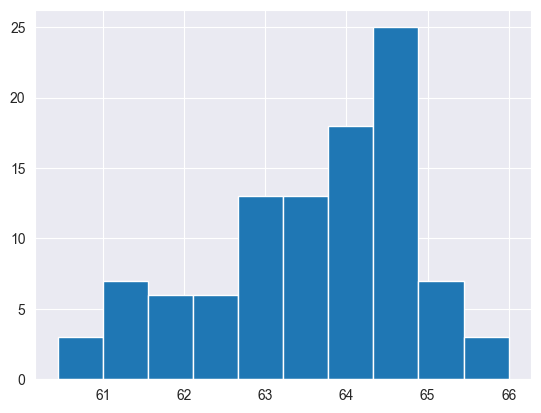

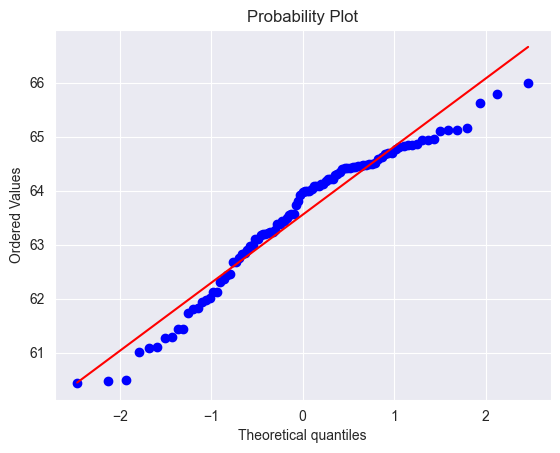

In [316]:
bounce_rate = data_frame[0]
bounce_rate.hist()
plt.show()
stats.probplot(bounce_rate, dist="norm", plot=plt)
plt.show()

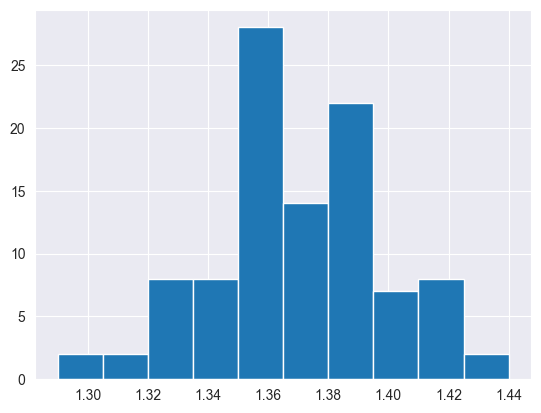

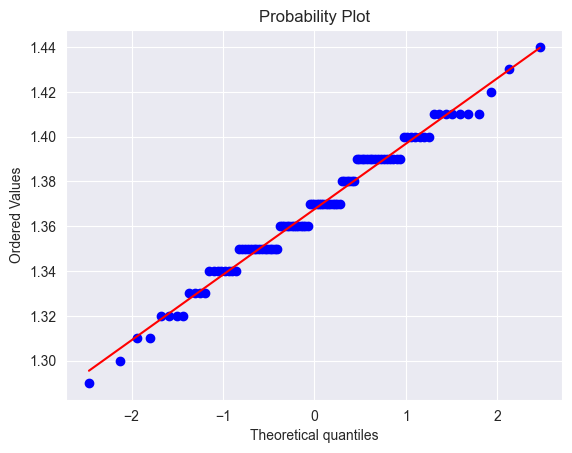

In [317]:
page_view = data_frame[1]
page_view.hist()
plt.show()
stats.probplot(page_view, dist="norm", plot=plt)
plt.show()

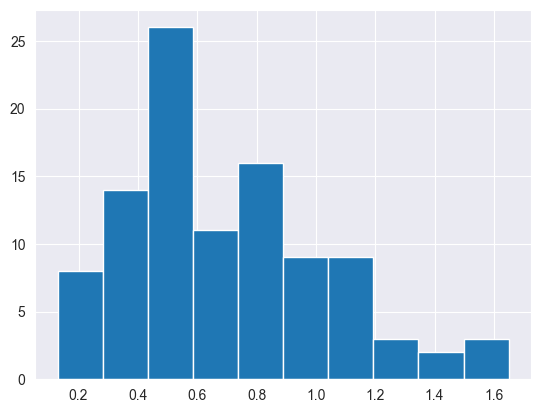

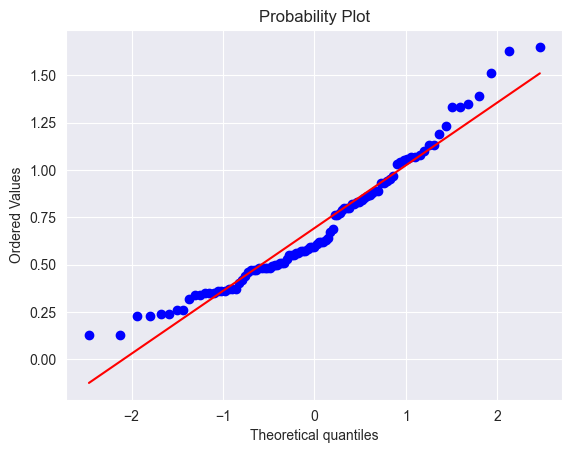

In [307]:
cr_order = data_frame[2]
cr_order.hist()
plt.show()
stats.probplot(cr_order, dist="norm", plot=plt)
plt.show()

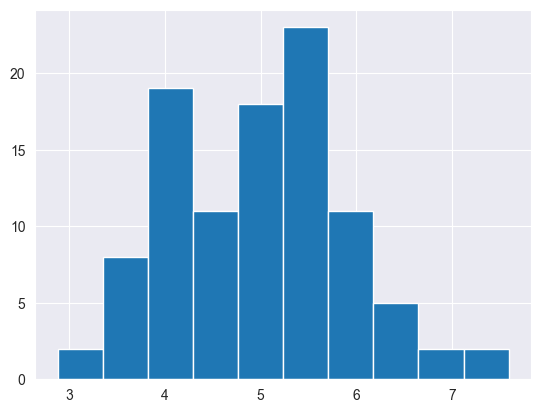

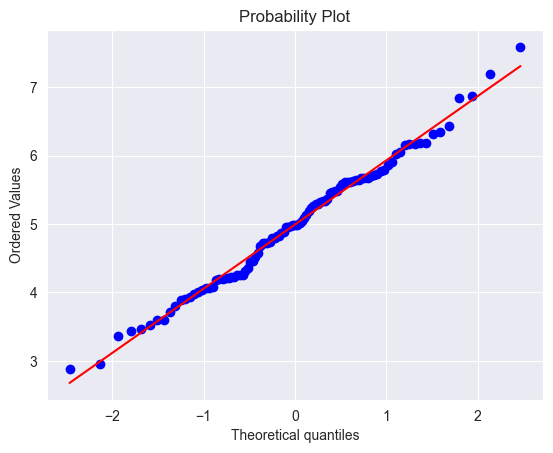

In [308]:
cr_all_forms = data_frame[3]
cr_all_forms.hist()
plt.show()
stats.probplot(cr_all_forms, dist="norm", plot=plt)
plt.show()

In [309]:
# Теперь возьмем 100 выборок по 10 000 наблюдений в каждой.

In [310]:
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export_1.csv', sep=',', header=None)

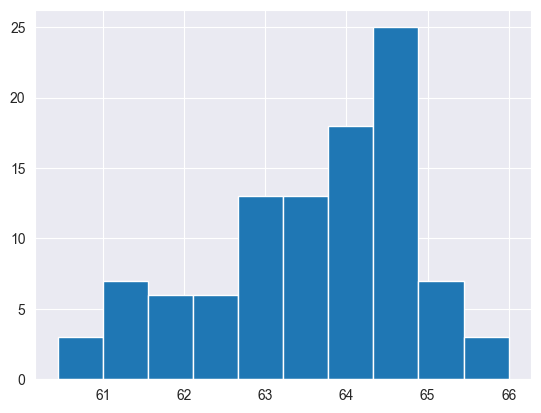

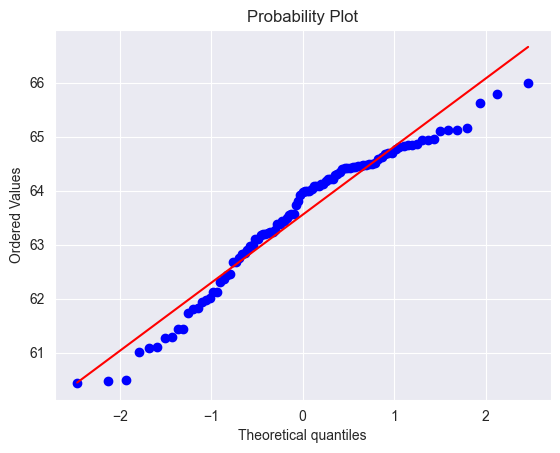

In [314]:
bounce_rate_1 = data_frame[0]
bounce_rate_1.hist()
plt.show()
stats.probplot(bounce_rate_1, dist="norm", plot=plt)
plt.show()

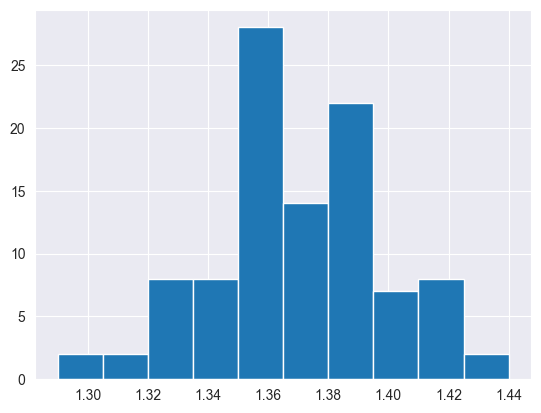

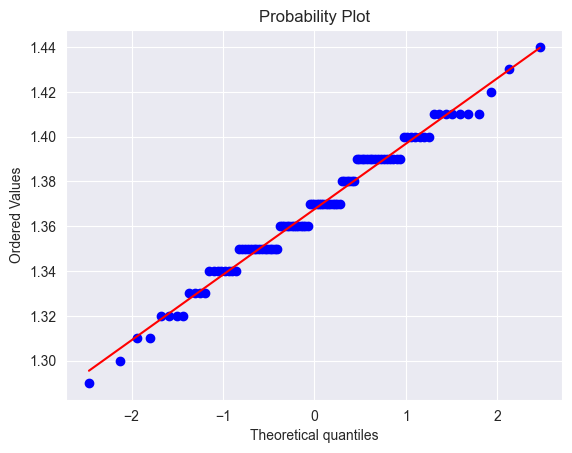

In [315]:
page_view_1 = data_frame[1]
page_view_1.hist()
plt.show()
stats.probplot(page_view_1, dist="norm", plot=plt)
plt.show()

In [313]:
# Внимание вопрос, какой тест нам применять?

In [319]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

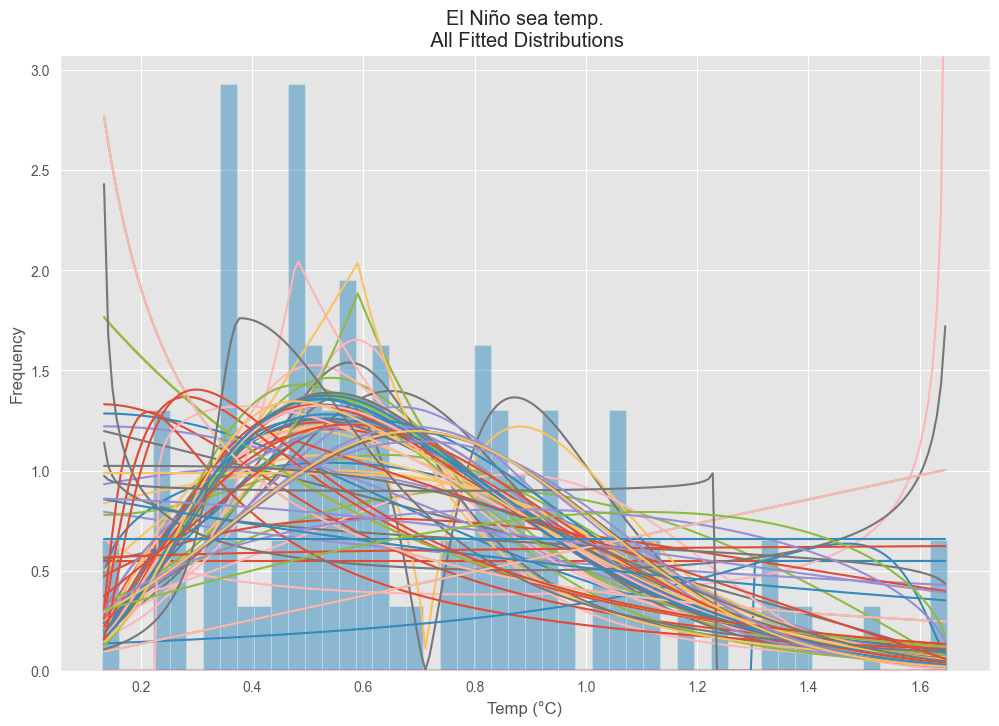

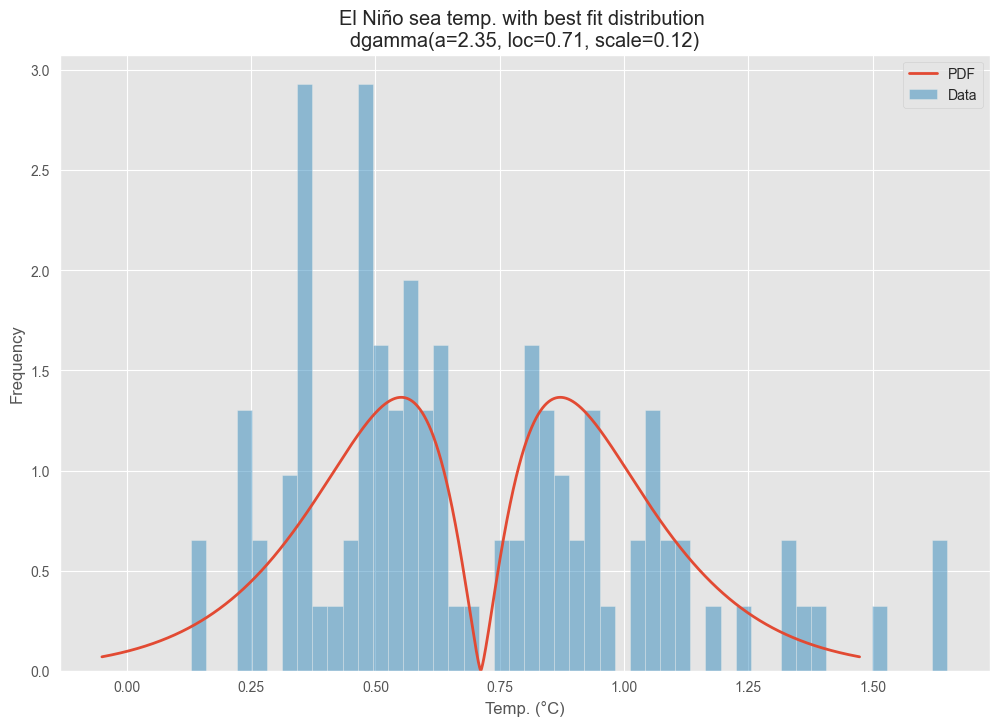

In [320]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = cr_order

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

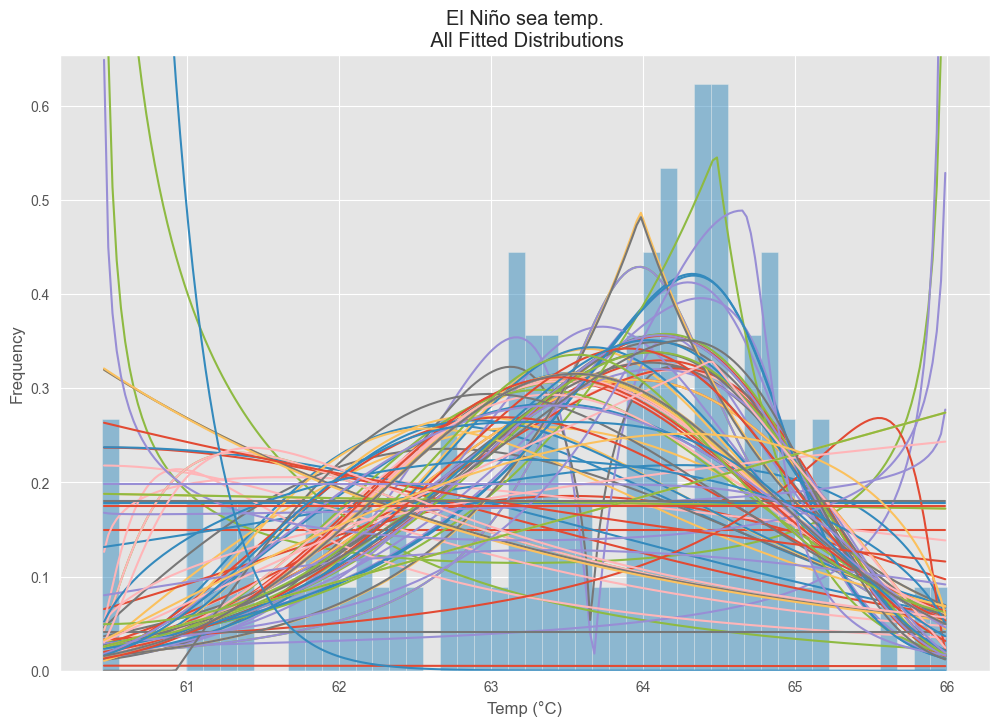

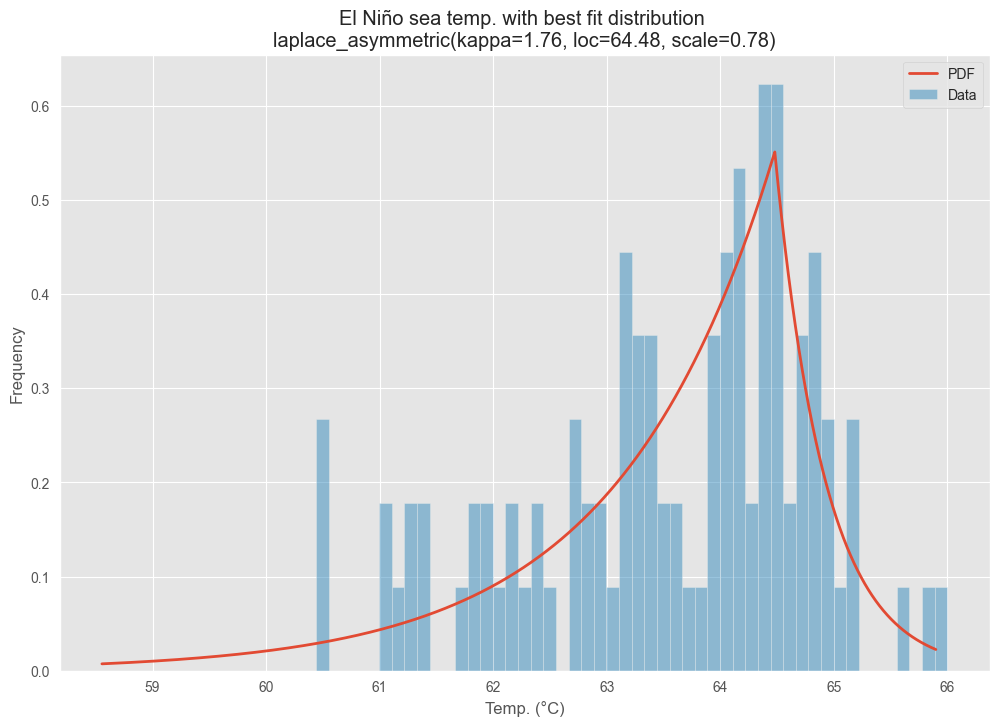

In [321]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = bounce_rate

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

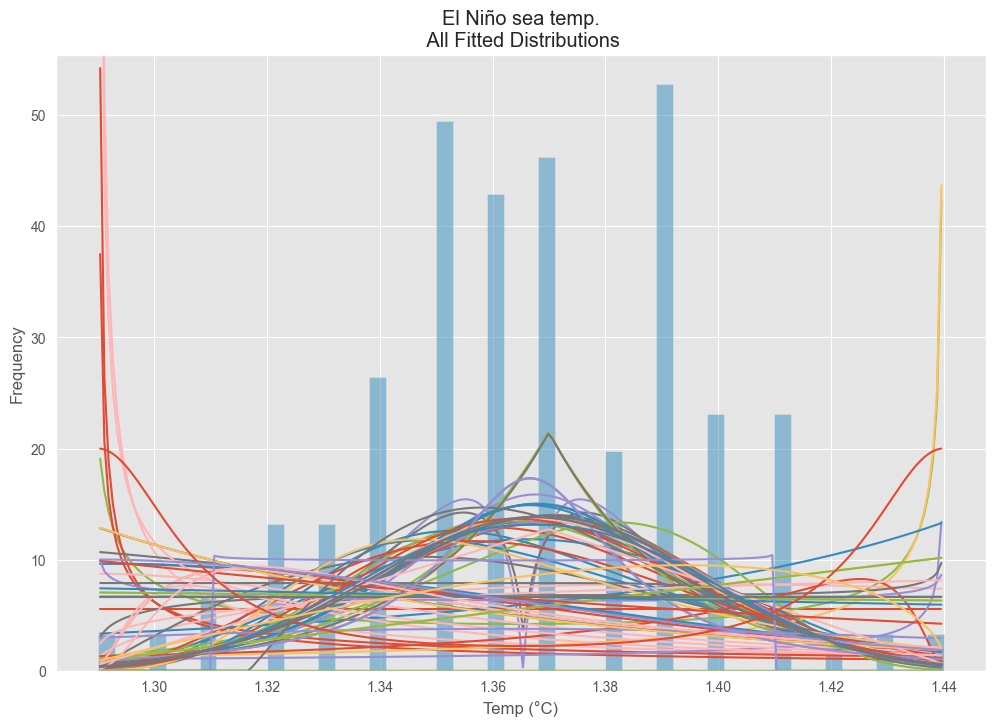

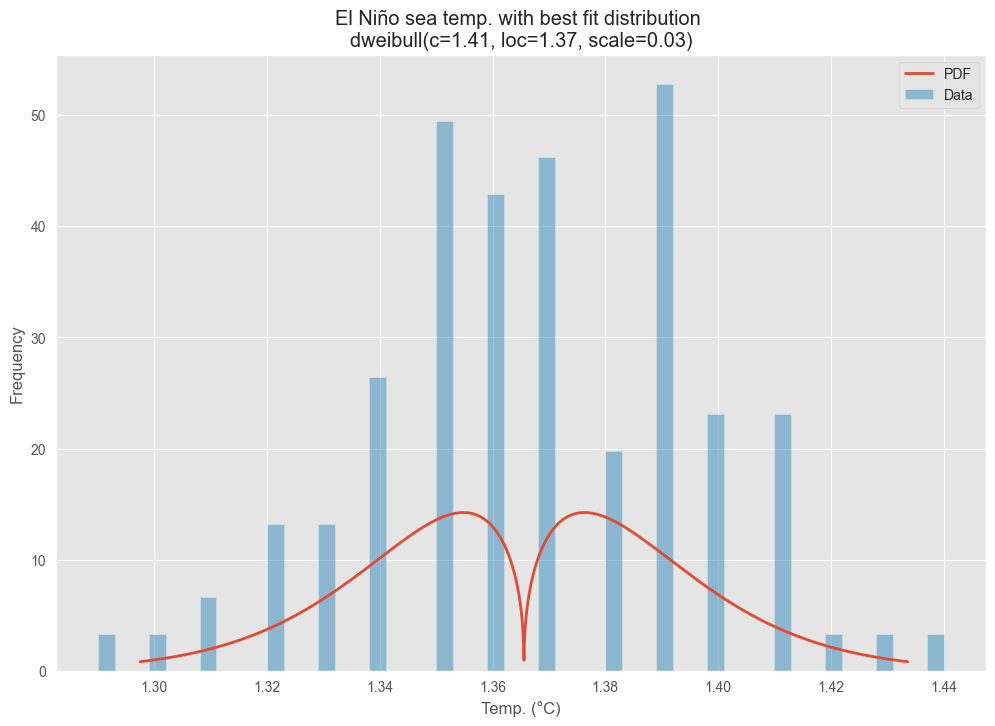

In [322]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = page_view

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

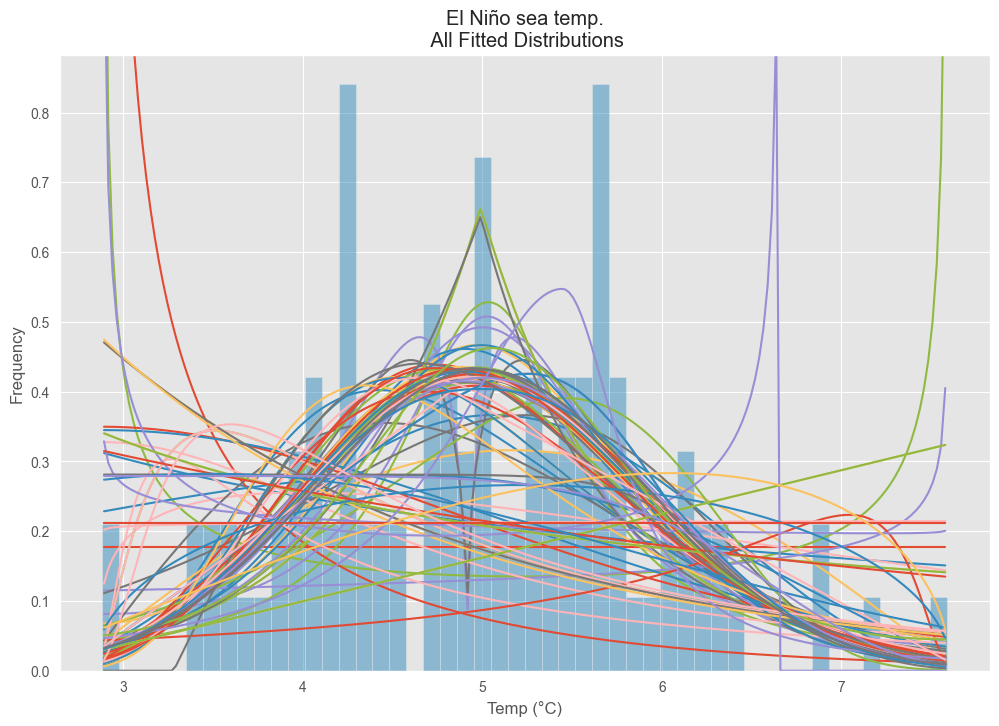

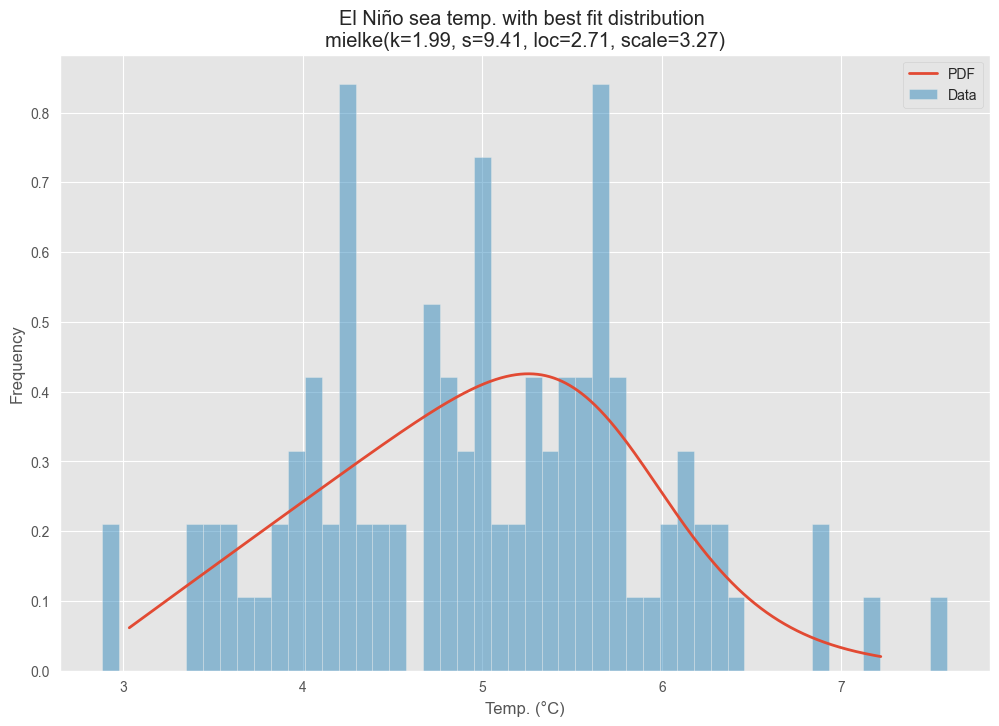

In [323]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = cr_all_forms

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

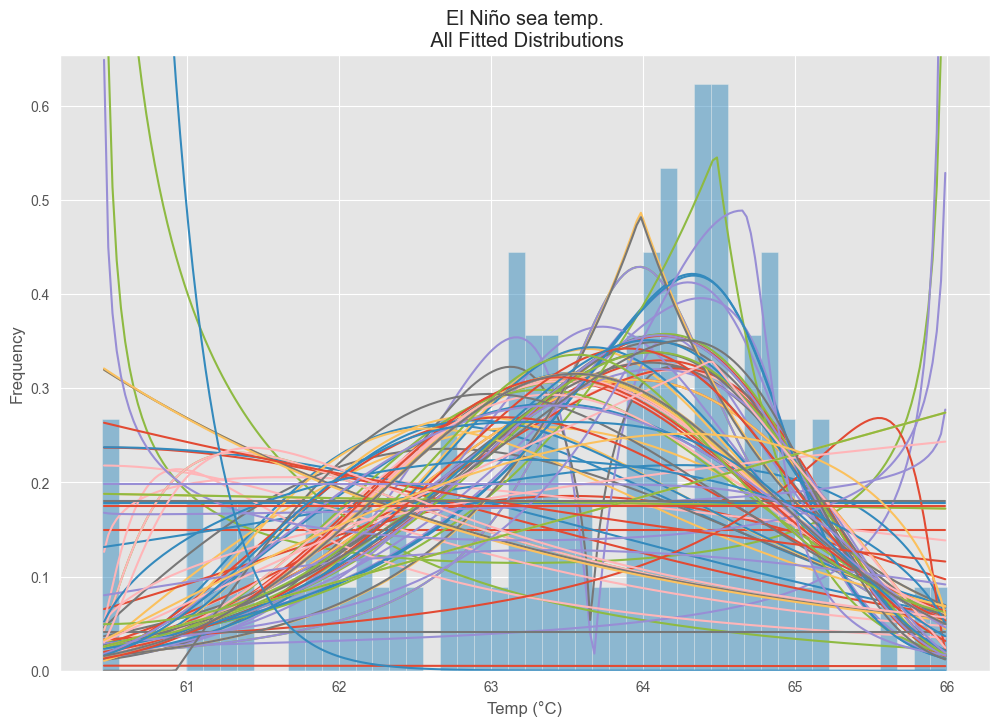

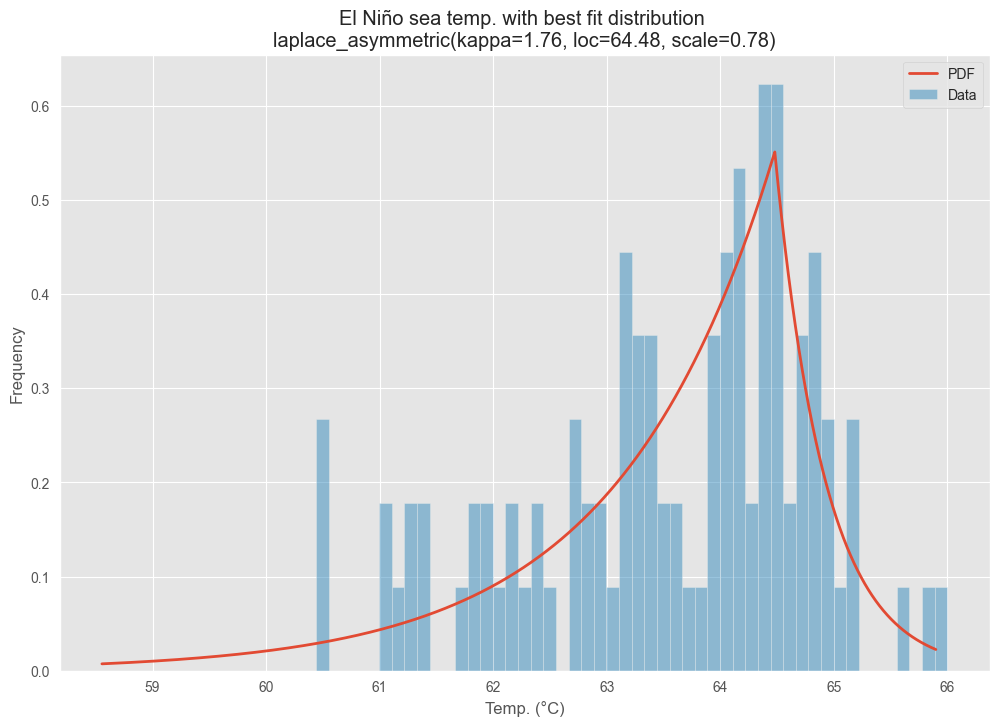

In [324]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = bounce_rate_1

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

  1 / 105: ksone
  2 / 105: kstwo
  3 / 105: kstwobign
  4 / 105: norm
  5 / 105: alpha
  6 / 105: anglit
  7 / 105: arcsine
  8 / 105: beta
  9 / 105: betaprime
 10 / 105: bradford
 11 / 105: burr
 12 / 105: burr12
 13 / 105: fisk
 14 / 105: cauchy
 15 / 105: chi
 16 / 105: chi2
 17 / 105: cosine
 18 / 105: dgamma
 19 / 105: dweibull
 20 / 105: expon
 21 / 105: exponnorm
 22 / 105: exponweib
 23 / 105: exponpow
 24 / 105: fatiguelife
 25 / 105: foldcauchy
 26 / 105: f
 27 / 105: foldnorm
 28 / 105: weibull_min
 29 / 105: truncweibull_min
 30 / 105: weibull_max
 31 / 105: genlogistic
 32 / 105: genpareto
 33 / 105: genexpon
 34 / 105: genextreme
 35 / 105: gamma
 36 / 105: erlang
 37 / 105: gengamma
 38 / 105: genhalflogistic
 39 / 105: genhyperbolic
 40 / 105: gompertz
 41 / 105: gumbel_r
 42 / 105: gumbel_l
 43 / 105: halfcauchy
 44 / 105: halflogistic
 45 / 105: halfnorm
 46 / 105: hypsecant
 47 / 105: gausshyper
 48 / 105: invgamma
 49 / 105: invgauss
 50 / 105: geninvgauss
 51 / 1

Text(0, 0.5, 'Frequency')

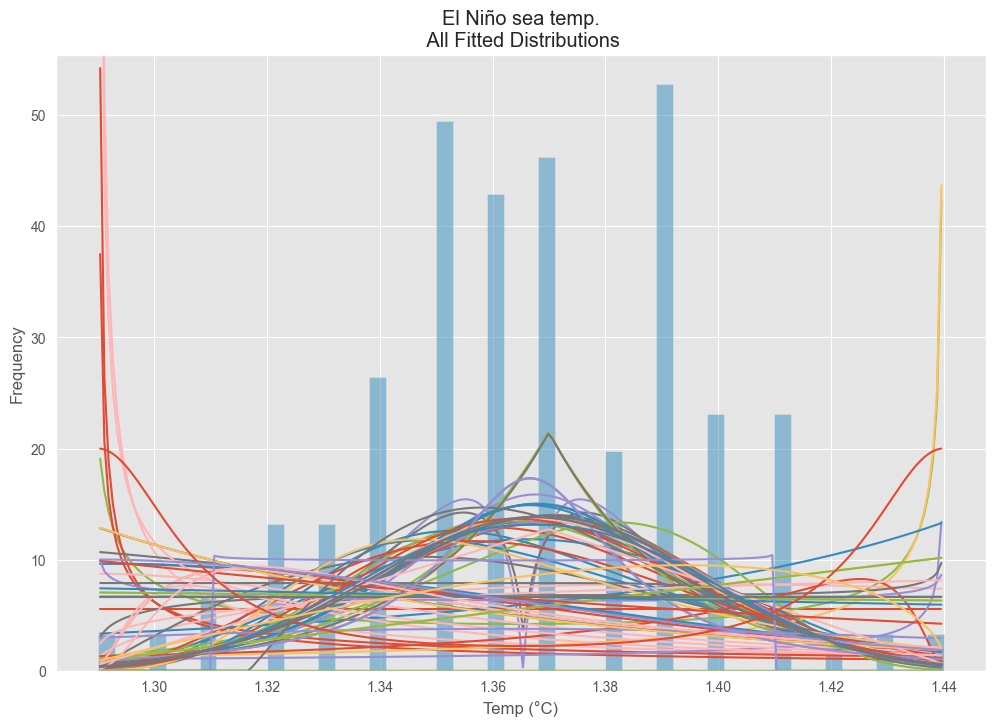

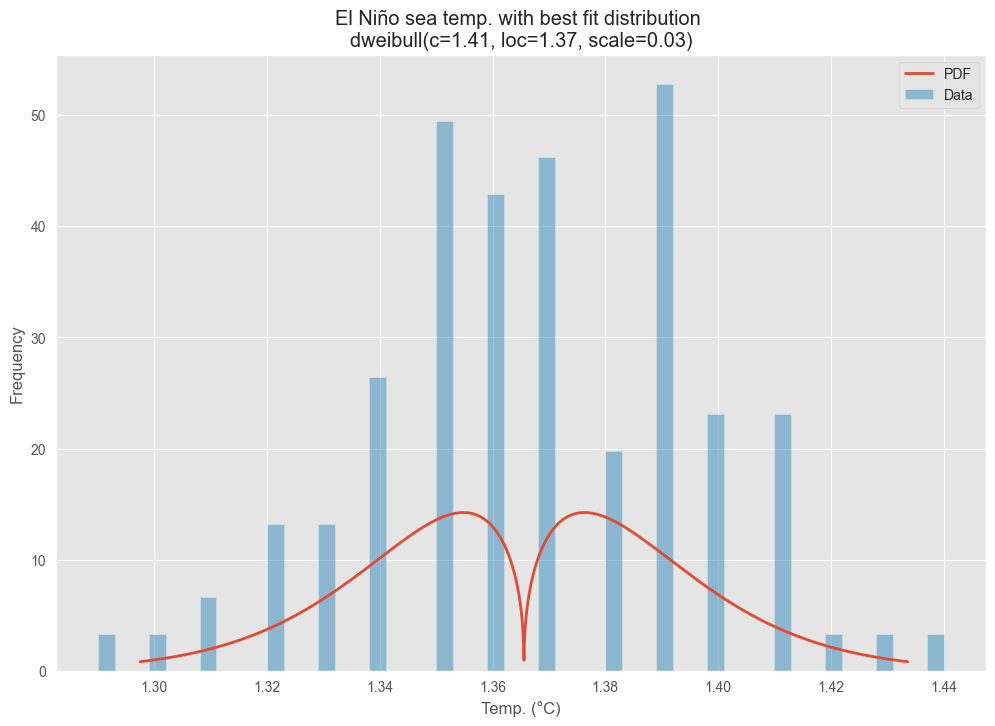

In [325]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = page_view_1

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [327]:
data_frame_2 = pd.read_csv('/Users/mitya/Downloads/cr_export_2.csv', sep=',', header=None)

In [332]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

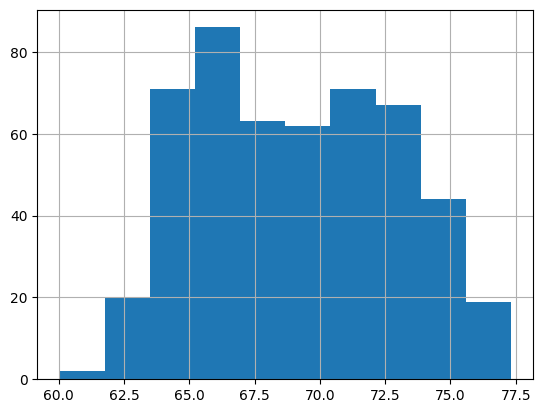

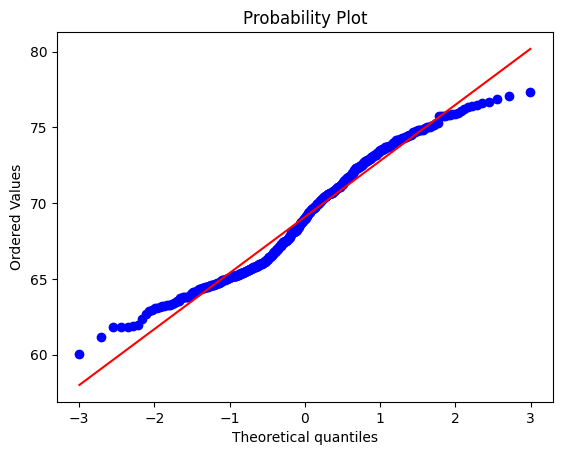

In [333]:
bounce_rate_2 = data_frame_2[0]
bounce_rate_2.hist()
plt.show()
stats.probplot(bounce_rate_2, dist="norm", plot=plt)
plt.show()

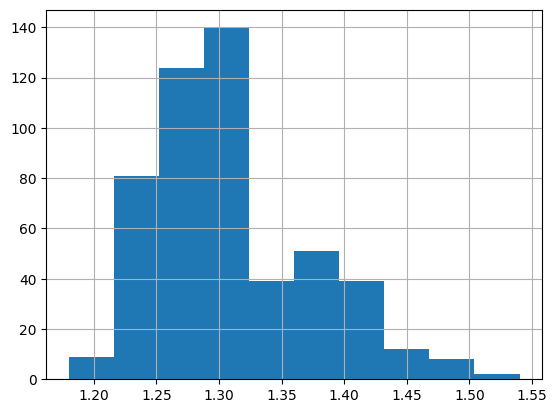

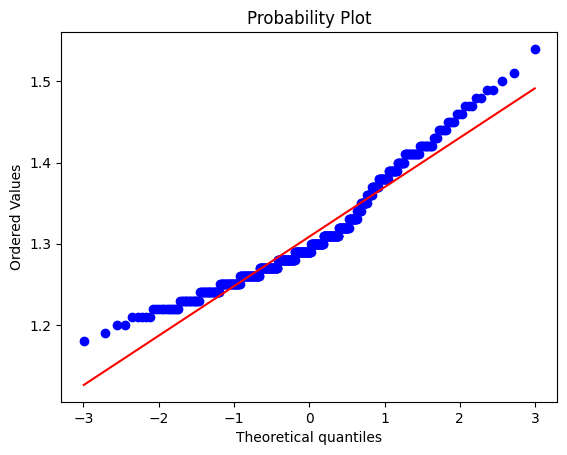

In [334]:
page_view_2 = data_frame_2[1]
page_view_2.hist()
plt.show()
stats.probplot(page_view_2, dist="norm", plot=plt)
plt.show()